# Example: Feature engineering
------------------------------

This example shows how to use automated feature generation to improve a model's performance.

The data used is a variation on the [Australian weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) from Kaggle. You can download it from [here](https://github.com/tvdboom/ATOM/blob/master/examples/datasets/weatherAUS.csv). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look
X.head()

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  MelbourneAirport     18.0     26.9      21.4          7.0       8.9   
1          Adelaide     17.2     23.4       0.0          NaN       NaN   
2            Cairns     18.6     24.6       7.4          3.0       6.1   
3          Portland     13.6     16.8       4.2          1.2       0.0   
4           Walpole     16.4     19.9       0.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity9am  \
0         SSE           41.0          W        SSE  ...         95.0   
1           S           41.0          S        WSW  ...         59.0   
2         SSE           54.0        SSE         SE  ...         78.0   
3         ESE           39.0        ESE        ESE  ...         76.0   
4          SE           44.0         SE         SE  ...         78.0   

   Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0         54.0       1019.5       1017.0       8.0       5.0     18.5   
1         36.0       1015.7       1015.7       NaN       NaN     17.7   
2         57.0       1018.7       1016.6       3.0       3.0     20.8   
3         74.0       1021.4       1020.5       7.0       8.0     15.6   
4         70.0       1019.4       1018.9       NaN       NaN     17.4   

   Temp3pm  RainToday  RainTomorrow  
0     26.0        Yes             0  
1     21.9         No             0  
2     24.1        Yes             0  
3     16.0        Yes             1  
4     18.1         No             0  

[5 rows x 22 columns]

## Run the pipeline

In [3]:
# Initialize atom and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0)
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)
atom.encode(max_onehot=10, rare_to_value=0.04)

In [4]:
atom.verbose = 2  # Increase verbosity to see the output

# Let's see how a LightGBM model performs
atom.run('LGB', metric='auc')


Training ========================= >>
Models: LGB
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9818
Test evaluation --> roc_auc: 0.8625
Time elapsed: 0.696s
-------------------------------------------------
Total time: 0.696s


Final results ==================== >>
Total time: 0.697s
-------------------------------------
LightGBM --> roc_auc: 0.8625


## Deep Feature Synthesis

In [5]:
# Since we are going to compare different datasets,
# we need to create separate branches
atom.branch = "dfs"

New branch dfs successfully created.


In [6]:
# Create 50 new features using dfs
atom.feature_generation("dfs", n_features=50, operators=["add", "sub", "log"])

Fitting FeatureGenerator...
Generating new features...
 --> 50 new features were added.


In [7]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the nans attribute
atom.nans

NATURAL_LOGARITHM(Cloud3pm)        332
NATURAL_LOGARITHM(Evaporation)      19
NATURAL_LOGARITHM(Rainfall)       6351
dtype: int64

In [8]:
# Turn off warnings in the future
atom.warnings = False

# Impute the data again to get rid of the missing values
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)

Fitting Imputer...
Imputing missing values...
 --> Imputing 332 missing values using the KNN imputer in feature NATURAL_LOGARITHM(Cloud3pm).
 --> Imputing 19 missing values using the KNN imputer in feature NATURAL_LOGARITHM(Evaporation).
 --> Imputing 6351 missing values using the KNN imputer in feature NATURAL_LOGARITHM(Rainfall).


In [9]:
# 50 new features may be to much...
# Let's check for multicollinearity and use rfecv to reduce the number
atom.feature_selection(
    strategy="rfecv",
    solver="LGB",
    n_features=30,
    scoring="auc",
    max_correlation=0.98,
)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature MinTemp was removed due to collinearity with another feature.
 --> Feature Location + MaxTemp was removed due to collinearity with another feature.
 --> Feature Location + Rainfall was removed due to collinearity with another feature.
 --> Feature Sunshine was removed due to collinearity with another feature.
 --> Feature Sunshine + WindGustDir was removed due to collinearity with another feature.
 --> Feature RainToday_No + WindGustSpeed was removed due to collinearity with another feature.
 --> Feature WindSpeed9am was removed due to collinearity with another feature.
 --> Feature WindSpeed3pm was removed due to collinearity with another feature.
 --> Feature Humidity3pm was removed due to collinearity with another feature.
 --> Feature Humidity3pm + RainToday_rare was removed due to collinearity with another feature.
 --> Feature Humidity3pm - WindDir9am was removed due to collinearity with another feature.
 --

In [10]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

drop  \
0                          MinTemp   
1               Location + MaxTemp   
2              Location + Rainfall   
3                         Sunshine   
4           Sunshine + WindGustDir   
5     RainToday_No + WindGustSpeed   
6                     WindSpeed9am   
7                     WindSpeed3pm   
8                      Humidity3pm   
9     Humidity3pm + RainToday_rare   
10        Humidity3pm - WindDir9am   
11  NATURAL_LOGARITHM(Pressure9am)   
12       Pressure9am - WindGustDir   
13        Pressure3pm - WindDir3pm   
14           Cloud9am - WindDir3pm   
15       RainToday_No - WindDir9am   
16                   RainToday_Yes   
17        Location + RainToday_Yes   
18      RainToday_Yes - WindDir3pm   
19           Humidity3pm - MinTemp   
20   RainToday_rare - WindSpeed3pm   

                                         corr_feature              corr_value  
0                            MinTemp + RainToday_rare                  0.9999  
1                                             MaxTemp                     1.0  
2                                            Rainfall                     1.0  
3   RainToday_rare + Sunshine, Sunshine + WindGustDir          0.9995, 0.9999  
4                 Sunshine, RainToday_rare + Sunshine          0.9999, 0.9993  
5                                       WindGustSpeed                  0.9995  
6                       RainToday_rare + WindSpeed9am                     1.0  
7                           WindDir9am + WindSpeed3pm                     1.0  
8   Cloud3pm + Humidity3pm, Humidity3pm + RainToda...         0.996, 1.0, 1.0  
9   Humidity3pm, Cloud3pm + Humidity3pm, Humidity3...         1.0, 0.996, 1.0  
10  Humidity3pm, Cloud3pm + Humidity3pm, Humidity3...         1.0, 0.996, 1.0  
11             Pressure9am, Pressure9am - WindGustDir                1.0, 1.0  
12        Pressure9am, NATURAL_LOGARITHM(Pressure9am)                1.0, 1.0  
13                                        Pressure3pm                     1.0  
14                                           Cloud9am                  0.9998  
15                                       RainToday_No                  0.9906  
16  Location + RainToday_Yes, RainToday_Yes + Wind...     1.0, 0.9946, 0.9941  
17  RainToday_Yes, RainToday_Yes + WindGustDir, Ra...     1.0, 0.9946, 0.9941  
18  RainToday_Yes, Location + RainToday_Yes, RainT...  0.9941, 0.9941, 0.9824  
19                              Humidity3pm - MaxTemp                  0.9877  
20                       RainToday_Yes - WindSpeed3pm                  0.9988

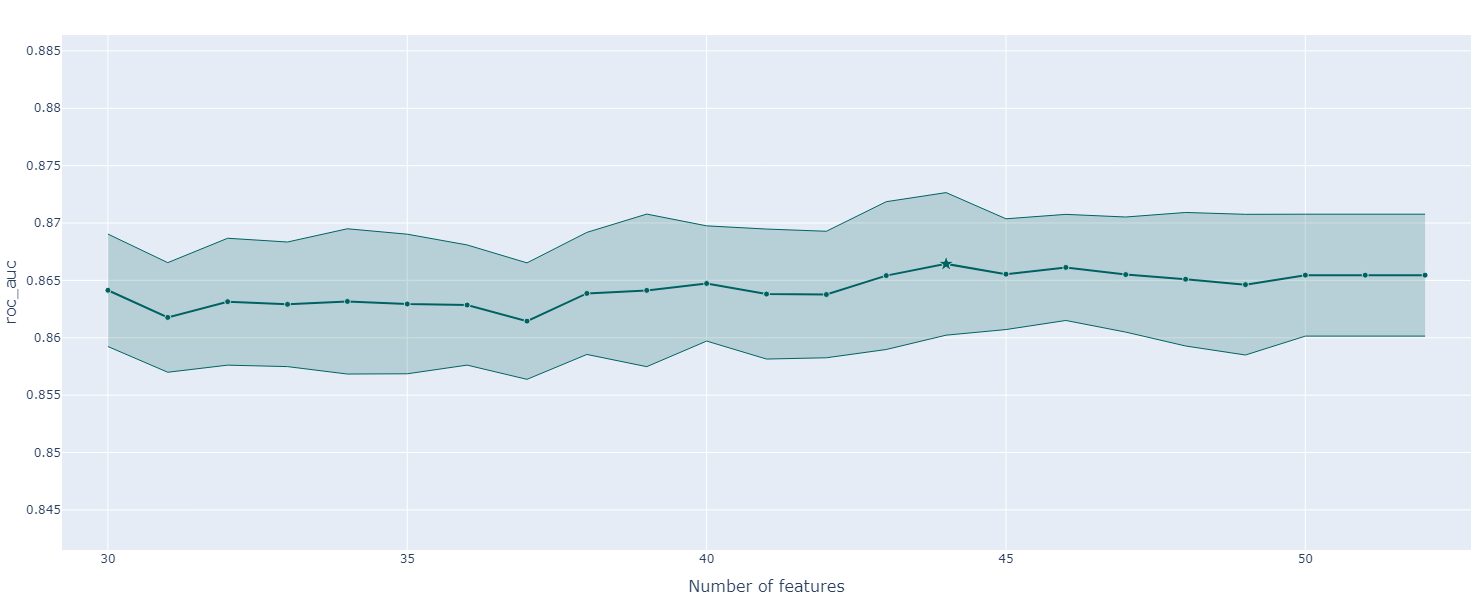

In [11]:
# After applying rfecv, we can plot the score per number of features
atom.plot_rfecv()

In [12]:
# Let's see how the model performs now
# Add a tag to the model's acronym to not overwrite previous LGB
atom.run("LGB_dfs")


Training ========================= >>
Models: LGB_dfs
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9906
Test evaluation --> roc_auc: 0.8616
Time elapsed: 1.485s
-------------------------------------------------
Total time: 1.485s


Final results ==================== >>
Total time: 1.485s
-------------------------------------
LightGBM --> roc_auc: 0.8616


## Genetic Feature Generation

In [13]:
# Create another branch for the genetic features
# Split form master to avoid the dfs features
atom.branch = "gfg_from_master"

New branch gfg successfully created.


In [14]:
# Create new features using Genetic Programming
atom.feature_generation(strategy='gfg', n_features=20)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.08         0.129852        3         0.485297              N/A     21.97s
   1     3.06         0.329673        3         0.492484              N/A     26.06s
   2     3.27         0.419512        5         0.510269              N/A     22.29s
   3     3.90          0.44394        6         0.512441              N/A     22.04s
   4     5.31         0.471916        9         0.516333              N/A     20.13s
   5     5.36         0.457234       10          0.51887              N/A     22.43s
   6     6.05         0.454503       16          0.51986              N/A     18.27s
   7     8.56         0.480404       16          0.51986              N/A     13.40s
   8     9.73         0.482795       16        

In [15]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features

name                                        description   fitness
0   x23  log(mul(add(add(WindGustSpeed, sub(Humidity3pm...  0.510691
1   x24  log(mul(add(sub(add(WindGustSpeed, Humidity3pm...  0.510691
2   x25  log(log(mul(add(sub(add(WindGustSpeed, Humidit...  0.510057
3   x26  log(log(mul(add(add(WindGustSpeed, sub(Humidit...  0.510057
4   x27  log(mul(mul(add(add(WindGustSpeed, sub(Humidit...  0.509417
5   x28  log(mul(mul(add(sub(add(WindGustSpeed, Humidit...  0.509417
6   x29  log(log(log(mul(add(add(WindGustSpeed, sub(Hum...  0.509197
7   x30  log(log(mul(mul(add(sub(add(WindGustSpeed, Hum...  0.508659
8   x31  log(log(log(log(mul(add(add(WindGustSpeed, sub...  0.508341
9   x32  log(log(log(mul(mul(add(add(WindGustSpeed, sub...  0.507739
10  x33  log(mul(add(mul(add(add(WindGustSpeed, sub(Hum...  0.507421
11  x34  log(mul(add(mul(add(sub(add(WindGustSpeed, Hum...  0.507421
12  x35  log(log(log(mul(add(mul(add(add(WindGustSpeed,...  0.505743
13  x36  log(log(mul(add(add(WindGustSpeed, add(add(Win...  0.505716
14  x37  log(mul(add(add(WindGustSpeed, mul(add(add(Win...  0.505426
15  x38  log(mul(add(add(WindGustSpeed, mul(add(sub(add...  0.505426
16  x39  log(mul(add(sub(mul(add(add(WindGustSpeed, sub...  0.505410
17  x40  log(mul(add(add(WindGustSpeed, sub(add(add(Win...  0.504868
18  x41  log(mul(add(add(WindGustSpeed, sub(Humidity3pm...  0.504868
19  x42  log(mul(add(add(WindGustSpeed, sub(add(sub(add...  0.504868

In [16]:
# Fit the model again
atom.run("LGB_gfg", metric="auc")


Training ========================= >>
Models: LGB_gfg
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9832
Test evaluation --> roc_auc: 0.8571
Time elapsed: 0.942s
-------------------------------------------------
Total time: 0.942s


Final results ==================== >>
Total time: 0.943s
-------------------------------------
LightGBM --> roc_auc: 0.8571


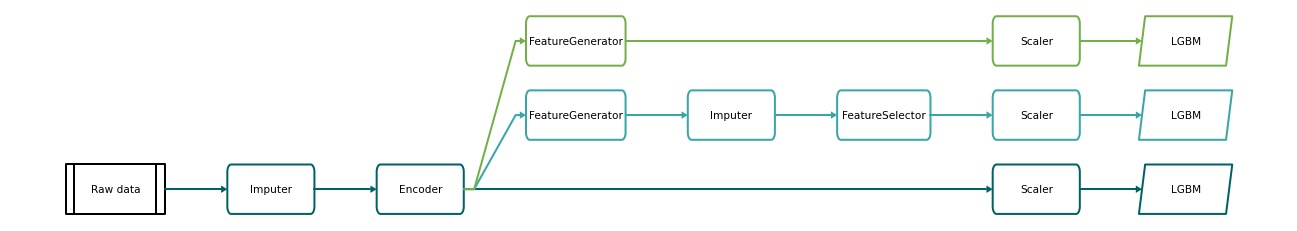

In [17]:
# Visualize the whole pipeline
atom.plot_pipeline()

## Analyze the results

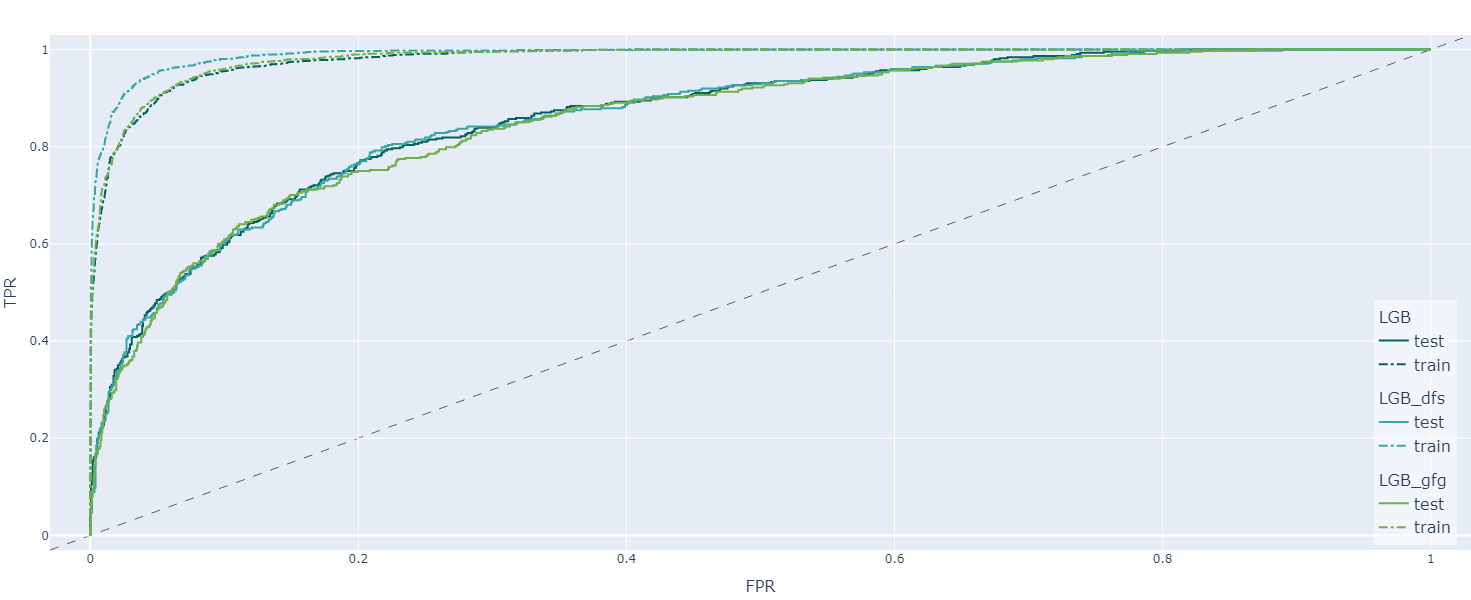

In [18]:
# Use atom's plots to compare the three models
atom.plot_roc(dataset="test+train")

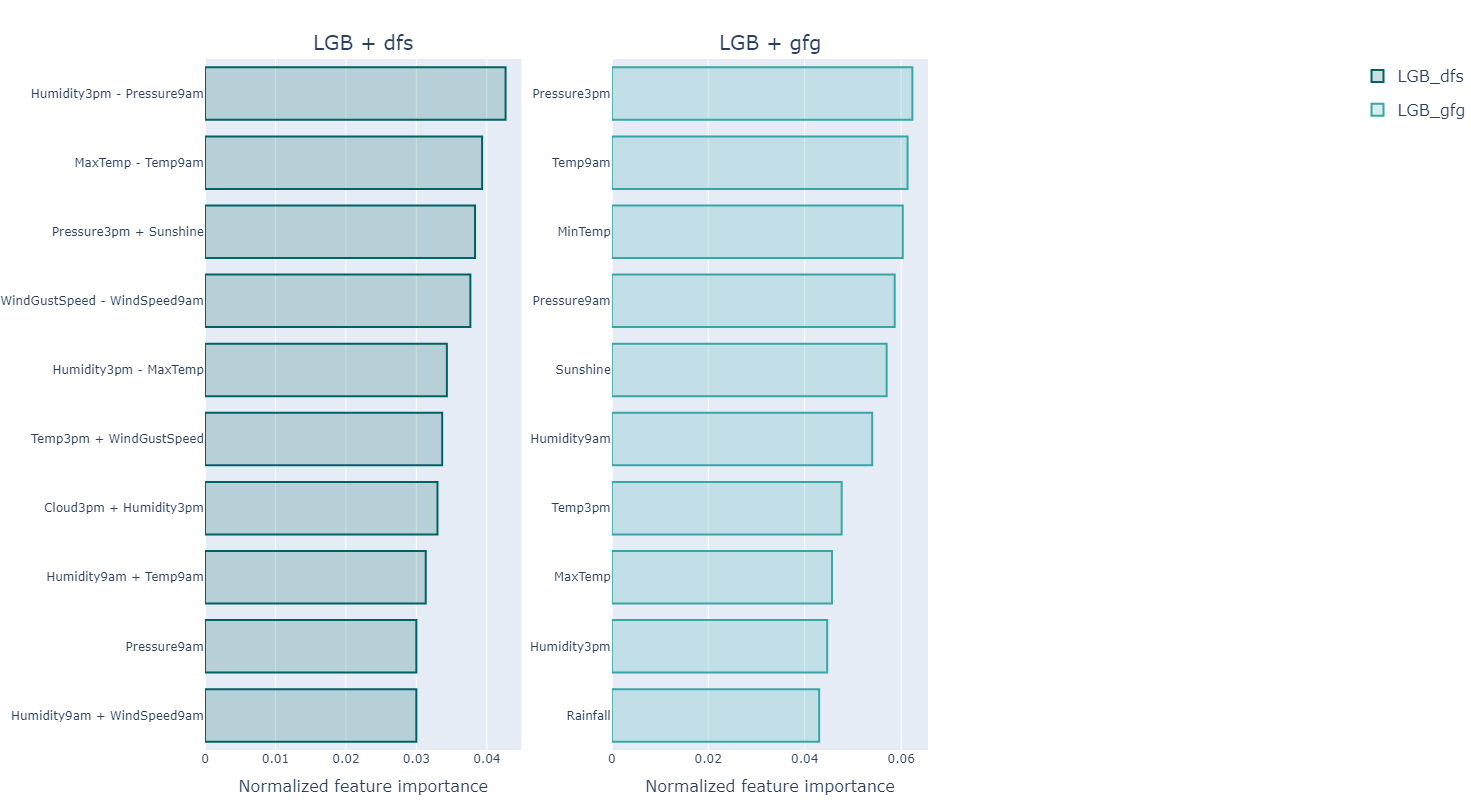

In [19]:
# To compare other plots it might be useful to use a canvas
with atom.canvas(1, 3, horizontal_spacing=0.08, figsize=(1800, 800)):
    atom.lgb_dfs.plot_feature_importance(show=10, title="LGB + dfs")
    atom.lgb_gfg.plot_feature_importance(show=10, title="LGB + gfg")

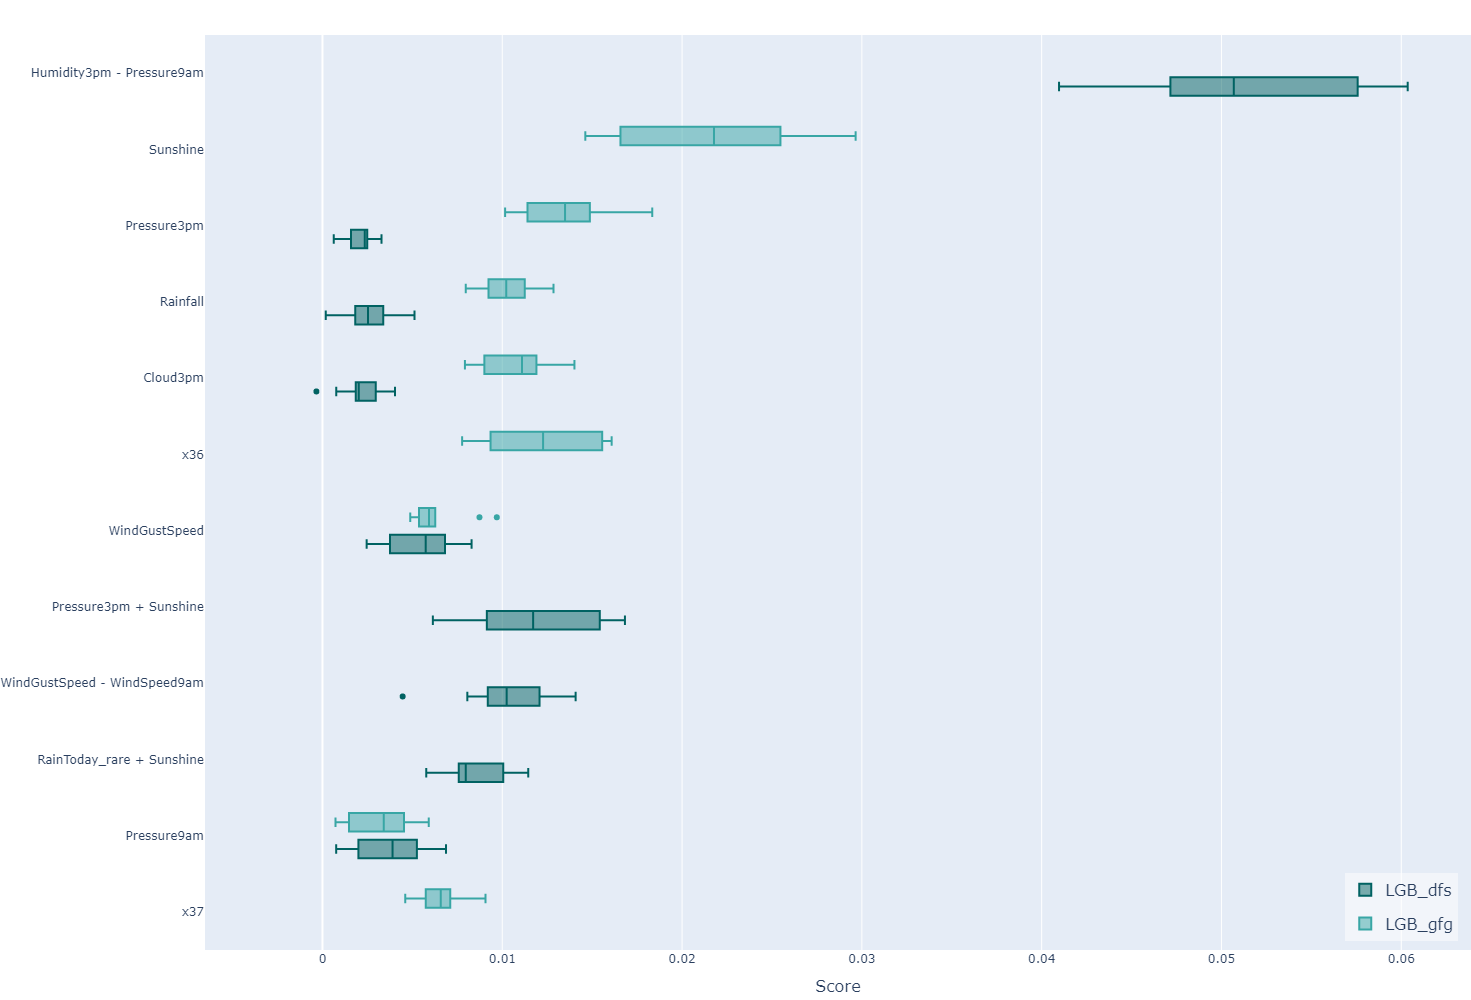

In [20]:
# We can check the feature importance with other plots as well
atom.plot_permutation_importance(models=["LGB_dfs", "LGB_gfg"], show=12)

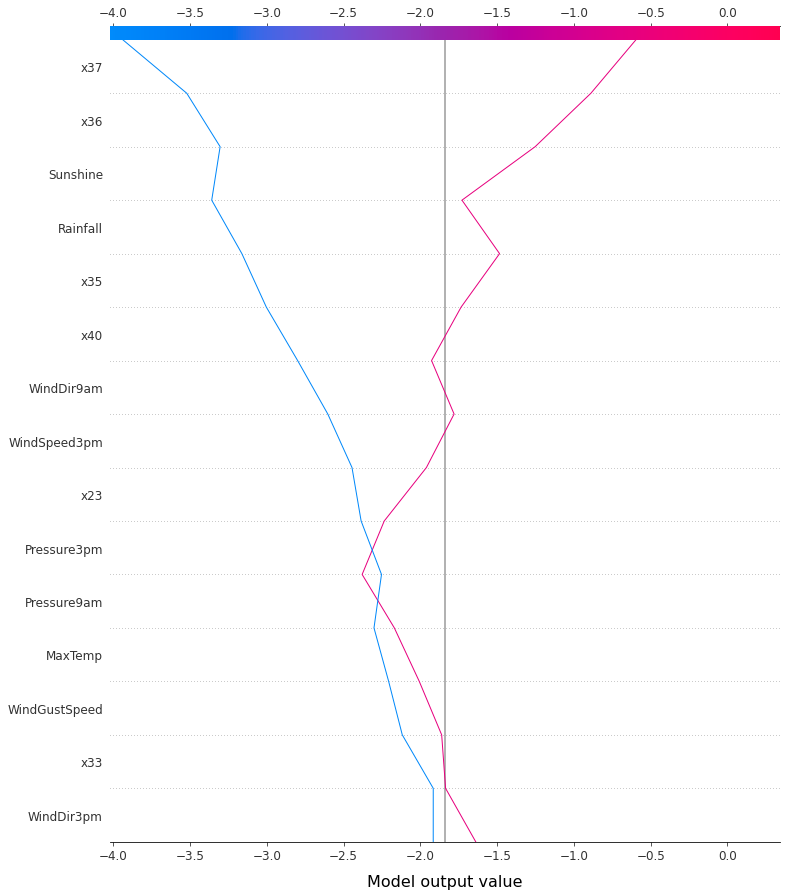

In [21]:
atom.LGB_gfg.plot_shap_decision(index=(0, 10), show=15)